# 2021-10-28 First deterministic fits with numerically integrated looming aversion values

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/4a7a415bc992544bd31bd1f5bfa4b6bd40c415ce (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

I have now:

* Refactored `sc_scenario_helper.get_access_order_values()` and `SCAgent.get_access_order_values_for_agent_v02()` a bit, since it is no longer enough to just have the predicted state at $t + T_p$, but instead quite a bit more info is needed also on the current state and the actions/behaviours to get from current to predicted state.
* Implemented the looming aversion in `sc_scenario_helper.get_access_order_values()`, now based on value rate $g_{free}$ instead of total future predicted value $V_{free}$.
* Added/modified a number of helper functions, and added/modified test code in `sc_scenario_helper.py`.

## Best/fastest way of preventing divide by zero warnings from numpy

The new helper function `sc_scenario_helper.get_app_entry_exit_time_arrays()` divides by speed arrays, so can generate divide by zero warnings. I can turn that off at a global numpy level with `np.seterr(divide='ignore')`, but I prefer to not do that (at least yet) since that would mean that I don't know if some code I add later introduce further division by zero. Below I am playing around with some different ways of dealing with this locally instead, showing that the fastest is just to leave the warnings there, and the second fastest is to set any zeros to `np.nan` before dividing (the `_v3()` implementation below - note that it doesn't yield nice Infs though). In the end I am for now going with just leaving the warnings there - so far in actual use the warning output hasn't been too disruptive.

In [11]:
import numpy as np

def unsafe_divide(a, b):
    return a/b

def safe_divide_v1(a, b):
    with np.errstate(divide='ignore'):
        return a/b

def safe_divide_v2(a, b):
    b[b == 0] = np.finfo(float).eps
    return a/b

def safe_divide_v3(a, b):
    b[b == 0] = np.nan
    return a/b

def safe_divide_v4(a, b):
    zero_denom = b == 0
    nonzero_denom = np.logical_not(zero_denom)
    c = np.zeros(len(a))
    c[zero_denom] = np.inf * a[zero_denom]
    c[nonzero_denom] = a[nonzero_denom] / b[nonzero_denom]
    return a/b

def safe_divide_v5(a, b):
    zero_denom = b == 0
    b[zero_denom] = np.nan
    c = a/b
    c[zero_denom] = np.inf * a[zero_denom]
    return c

a = np.full(50, 1.)
b = np.full(50, 2.)
b[10:20] = 0

%timeit unsafe_divide(a, b)
%timeit safe_divide_v1(a, b)
%timeit safe_divide_v2(a, b)
%timeit safe_divide_v3(a, b)
%timeit safe_divide_v4(a, b)
%timeit safe_divide_v5(a, b)

585 ns ± 40.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
4.51 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.97 µs ± 57.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.61 µs ± 34.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5.27 µs ± 77.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.65 µs ± 68.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Overview of results from deterministic fits with the new `oVAl` implementation

I have rerun all fits now (with the smaller/sparser parameter grid), just to check also for any problems I might have introduced while making these changes to allow for the improved `oVAl`. Comparing with the 2021-10-23 results, I do get exactly the same results as in that run, in terms of the number of parameterisations meeting the max number of main criteria; the only exception is a small increase in the number of parameterisations meeting the single main criterion met by `oVAaoBEooBEv` and `oVAaoBEv` (short-stopping for both). Not sure exactly what caused this change, but it is so small of a difference that I won't look further into it.

See further below for other more in-depth looks.

In [7]:
%run ../SCPaper/do_2_analyse_deterministic_fits

['C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEo.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEooBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEooBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVA.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAa.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEo.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEooBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEooBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_o

## Closer looks

### Successfully exhibiting early pedestrian crossing onset in `ActPedPrioEncounter` - but other stuff isn't working

Below plotting the example top-performing parameterisations of `oVAaoVAloBEo`, `oVAaoVAloBEvoAI`, and `oVAaoVAloBEooBEvoAI`; the three models I had highest hopes about for this run. In the end only `oVAaoVAloBEo` was somewhat satisfactory - it now shows an actual pedestrian hesitation + early crossing in the `ActPedPrioEncounter` scenario, in line with my experimentation while adding the integration-based `oVAL` assumption. 

But I don't see that behaviour at all in the other two models - they are instead immediately convinced that the pedestrian will pass in second. These models only ever achieve short-stopping, not even priority assertion, again seemingly because (with these parameterisations) they seem overconfident that the pedestrian will anyway pass in second.


*** oVAaoVAloBEo
{'T_delta': 15.0, 'thetaDot_1': 0.2, 'T_Of': 0.5, 'sigma_O': 2.5}
{'veh_assert_prio': False, 'veh_short_stop': False, 'ped_hesitate_dec': True, 'ped_start_bef_veh_stop': True}
	--- ActVehStatPed


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


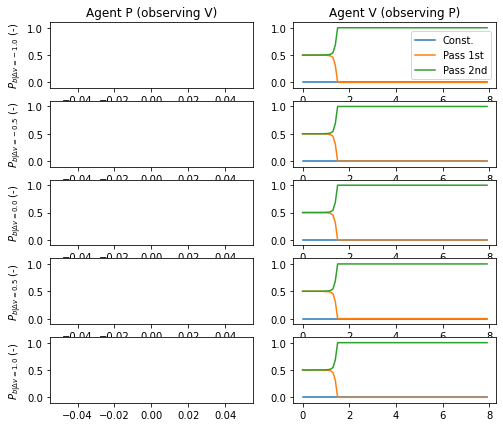

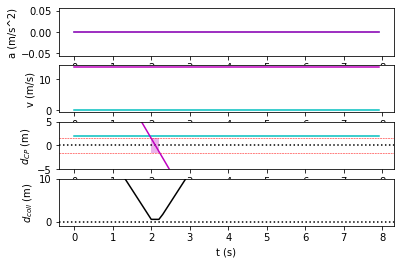

	--- ActVehStatPedPrio


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


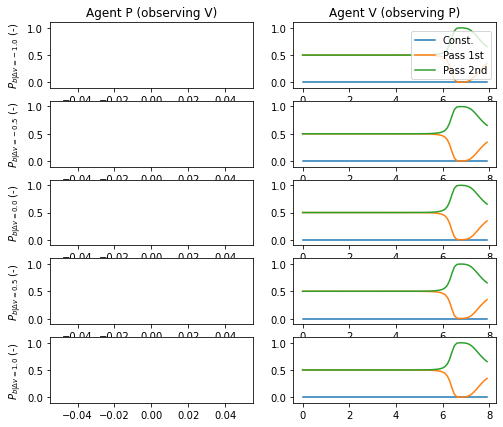

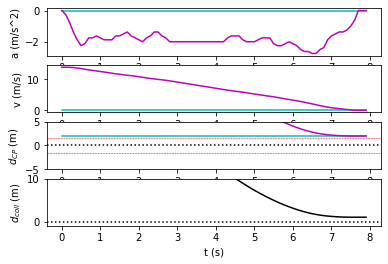

	--- ActPedPrioEncounter


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


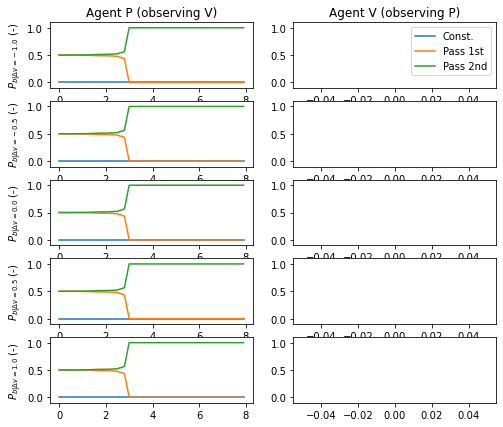

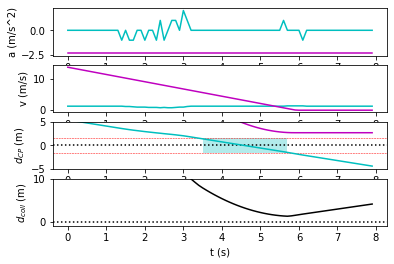


*** oVAaoVAloBEvoAI
{'T_delta': 15.0, 'thetaDot_1': 0.1, 'beta_V': 135.0}
{'veh_assert_prio': False, 'veh_short_stop': True, 'ped_hesitate_dec': False, 'ped_start_bef_veh_stop': False}
	--- ActVehStatPed


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


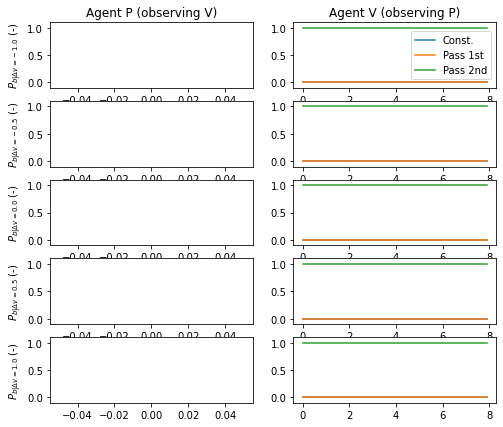

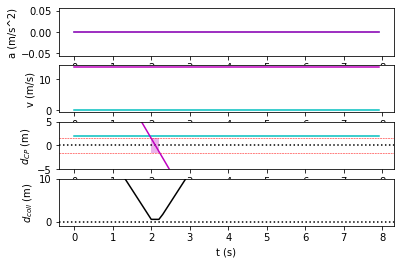

	--- ActVehStatPedPrio


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


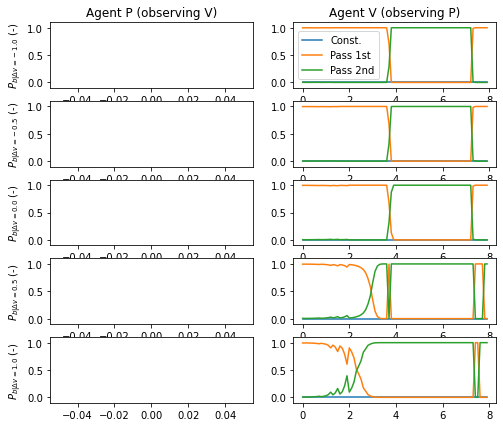

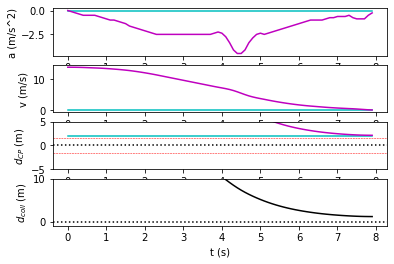

	--- ActPedPrioEncounter


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


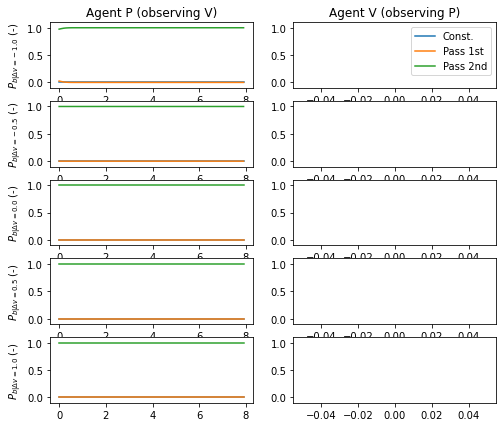

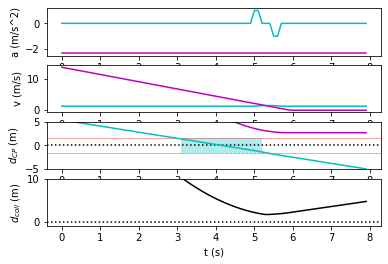


*** oVAaoVAloBEooBEvoAI
{'T_delta': 15.0, 'thetaDot_1': 0.05, 'beta_V': 135.0, 'T_Of': 2.0, 'sigma_O': 0.02}
{'veh_assert_prio': False, 'veh_short_stop': True, 'ped_hesitate_dec': False, 'ped_start_bef_veh_stop': False}
	--- ActVehStatPed


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


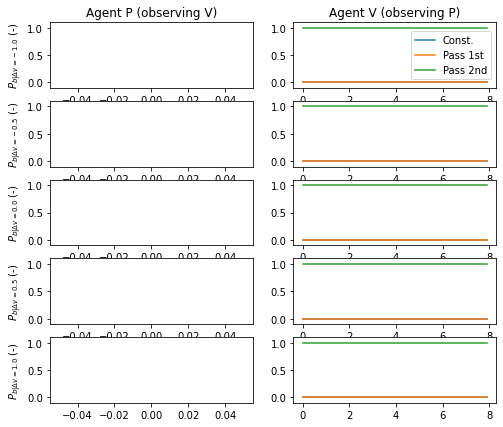

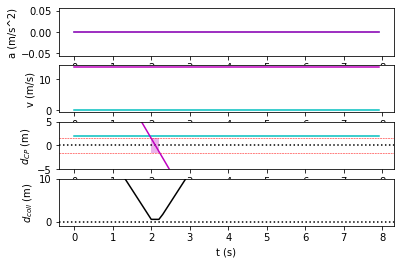

	--- ActVehStatPedPrio


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


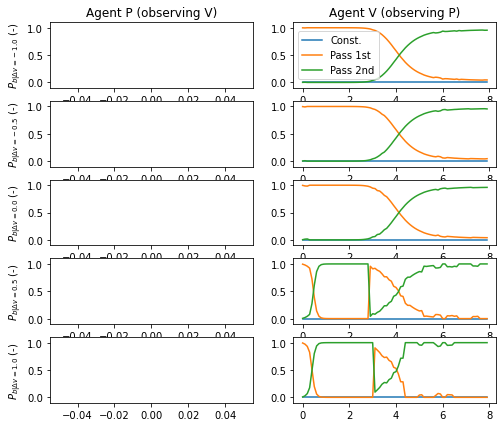

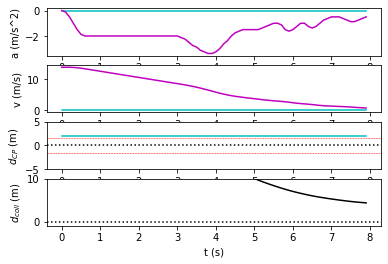

	--- ActPedPrioEncounter


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


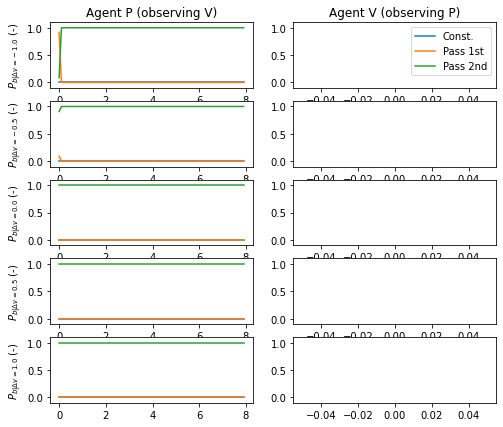

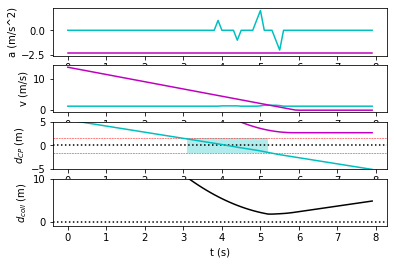

In [15]:
for model in ('oVAaoVAloBEo', 'oVAaoVAloBEvoAI', 'oVAaoVAloBEooBEvoAI'):
    print(f'\n*** {model}')
    fit = det_fits[model]
    ex = fit.example
    print(ex.params_dict)
    print(ex.main_crit_dict)
    fit.set_params(ex.params_array)
    for scenario in ('ActVehStatPed', 'ActVehStatPedPrio', 'ActPedPrioEncounter'):
        print(f'\t--- {scenario}')
        sim = fit.simulate_scenario(sc_fitting.DET1S_SCENARIOS[scenario])
        sim.do_plots(kinem_states=True, beh_probs=True)

### One reason the `oVAa` models aren't doing priority assertion is because they assume unrealistic pedestrian behaviour

Looking closer at the `oVAaoVAloBEvoAI` to try to figure out why it doesn't exhibit any priority assertion, I take the same parameterisation as above, and dial down $\beta_V$ from 135 to 5. This now gives a car model that isn't initially overly certain that the pedestrian will pass in second in the `ActVehStatPed` scenario, but it still doesn't acceleration to assert priority. A closer look at the snapshot below shows that the reason for this is that the `oVAa` assumption means that when the pedestrian is the "other" agent, the assumed future movement is to maintain the constant acceleration needed to achieve the pass first/second behaviour in question. For this reason, in the snapshot below the car thinks that if the pedestrian decides to pass first it will apply and maintain a 3-5 m/s^2 acceleration for about a second, which is comparable to what a running athlete achieves during the first second of a full-speed sprint from starting blocks (Nagahara et al, 2018). With this assumption about the pedestrian, the car doesn't need to adapt its speed at all in order to pass behind the pedestrian - indeed this is an inherent problem with the `oVAa` models as (sort of?) noted before: If the ego agent is at a nice constant speed, both possible behaviours of the other agent will be unproblematic for the ego agent, because they are adapted to nicely pass before/after the ego agent. I thought that the `oVAl` assumption could counteract this, and indeed we can see in the snapshot below that there is a looming cost to the ego agent for passing in second, but it is quite small (-0.2). 

{'T_delta': 15, 'thetaDot_1': 0.1, 'beta_V': 5}
	--- ActVehStatPed


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:

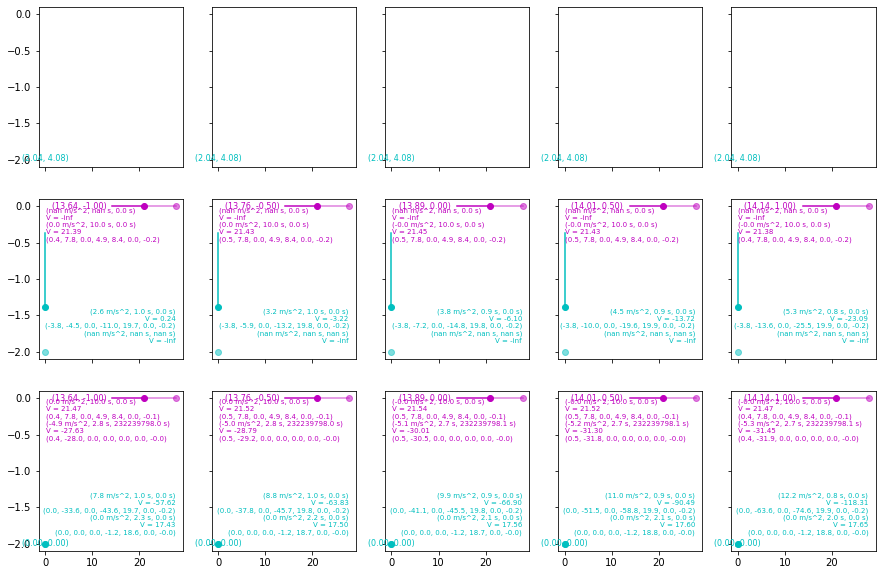

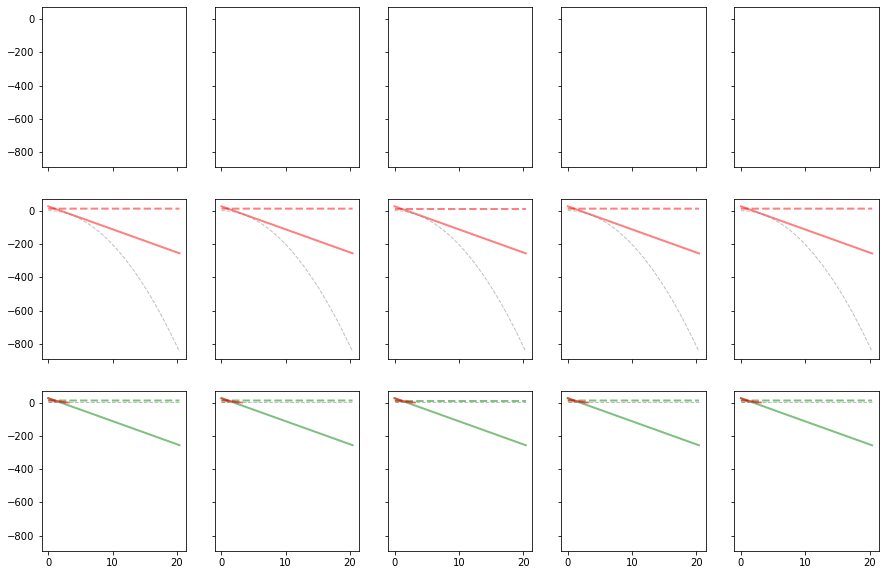

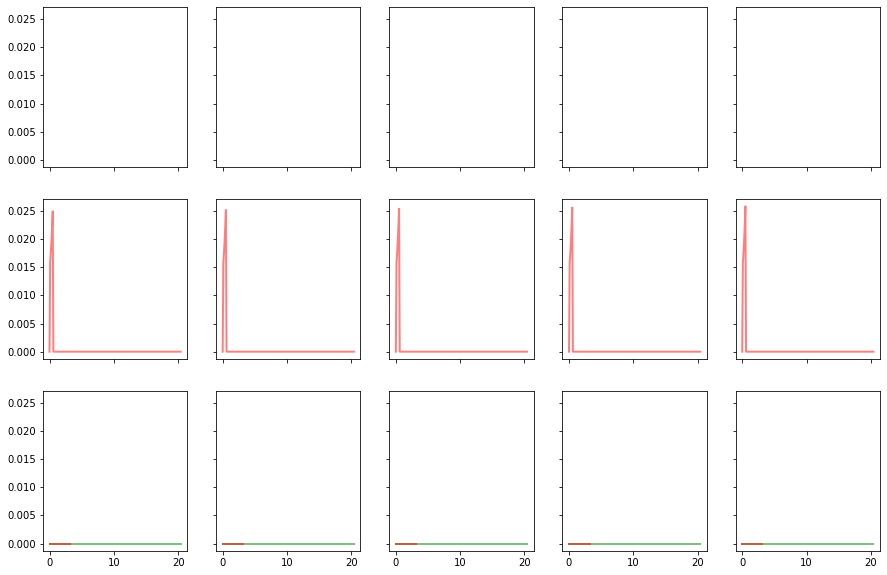

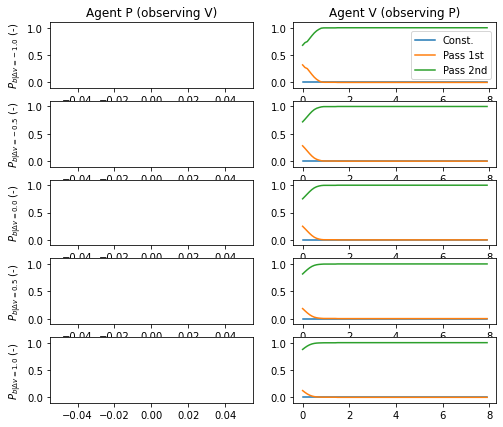

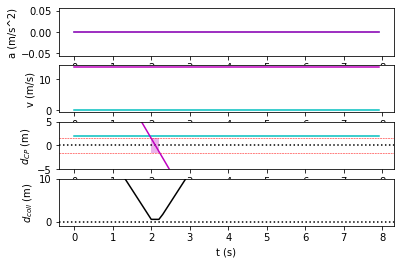

	--- ActVehStatPedPrio


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


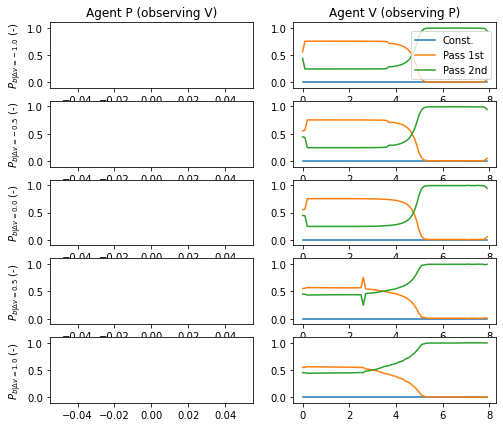

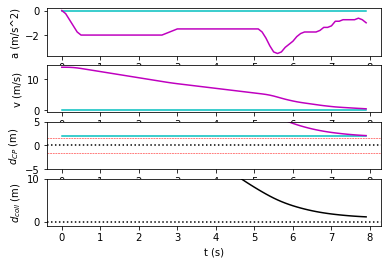

	--- ActPedPrioEncounter


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


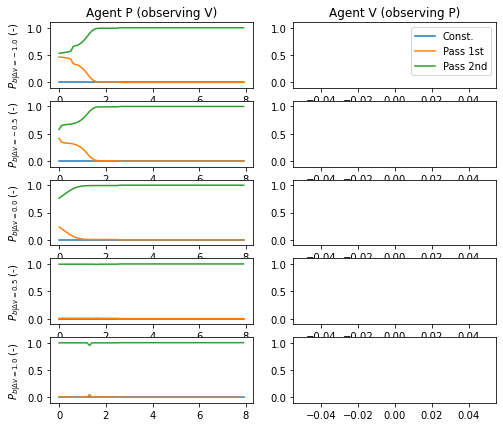

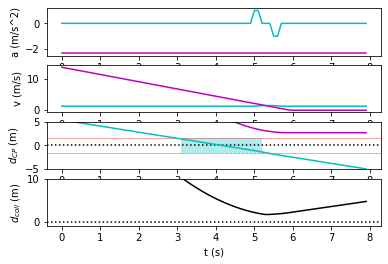

In [30]:
fit = det_fits['oVAaoVAloBEvoAI']
params_array = (15, 0.1, 5)
fit.set_params(params_array)
print(fit.get_params_dict(params_array))
for scenario in ('ActVehStatPed', 'ActVehStatPedPrio', 'ActPedPrioEncounter'):
    print(f'\t--- {scenario}')
    if scenario == 'ActVehStatPed':
        snapshots = (None, (0.1,))
    else:
        snapshots = (None, None)
    sim = fit.simulate_scenario(sc_fitting.DET1S_SCENARIOS[scenario], snapshots=snapshots)
    sim.do_plots(kinem_states=True, beh_probs=True)

### One reason the `oVAa*oBEv*` models aren't showing pedestrian hesitation + before-stopping crossing is that they are asserting priority

It can be noted in the last simulation above that here the pedestrian doesn't slow down even though it isn't initially certain that the vehicle will pass in second. And part of the reason for this seems to be that it is actually asserting priority by not slowing down. So it might be hard to get a model that both does priority assertion by the vehicle in the `ActVehStatPed` scenario, and pedestrian deceleration in the `ActPedPrioEncounter` scenario.


### Another reason the `oVAa` models aren't doing priority assertion is because I didn't allow for sufficiently large looming aversion

By decreasing $\dot{\theta}_1$ from 0.1 rad/s to 0.01 rad/s I can make priority assertion appear, but with this parameterisation the pedestrian doesn't ever start walking in the `ActPedPrioEncounter` scenario:

{'T_delta': 15, 'thetaDot_1': 0.01, 'beta_V': 5}
	--- ActVehStatPed


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


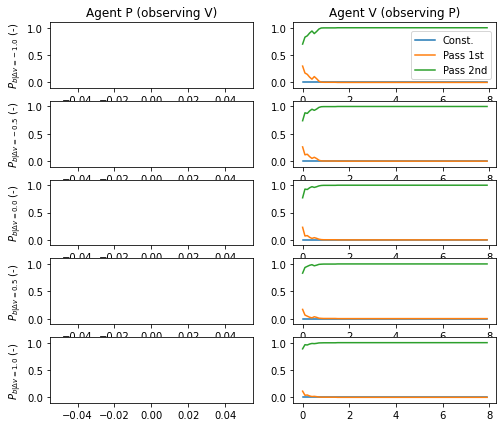

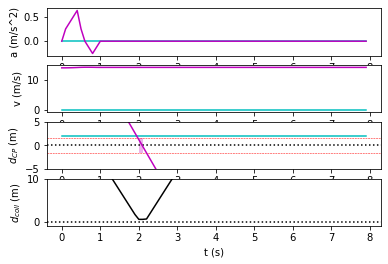

	--- ActVehStatPedPrio


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


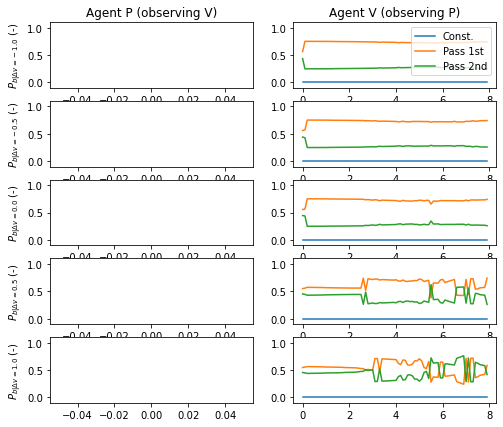

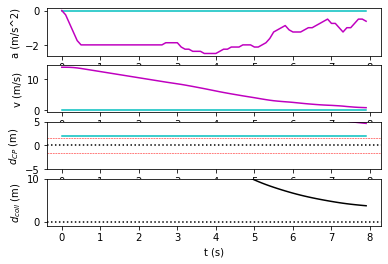

	--- ActPedPrioEncounter


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


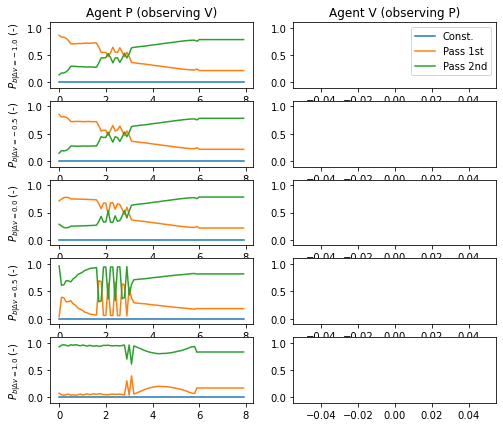

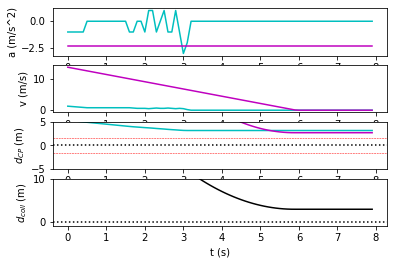

In [32]:
fit = det_fits['oVAaoVAloBEvoAI']
params_array = (15, 0.01, 5)
fit.set_params(params_array)
print(fit.get_params_dict(params_array))
for scenario in ('ActVehStatPed', 'ActVehStatPedPrio', 'ActPedPrioEncounter'):
    print(f'\t--- {scenario}')
    sim = fit.simulate_scenario(sc_fitting.DET1S_SCENARIOS[scenario], snapshots=snapshots)
    sim.do_plots(kinem_states=True, beh_probs=True)

Bringing in the `oBEo` assumption, it seems I can actually find a parameterisation which shows a little bit of hesitation in the deceleration scenario, and then speeds up and passes before the vehicle comes to a stop. And at the same time there is also priority assertion and what almost counts as short-stopping with my current criterion definition (2 m/s^2 surplus deceleration, the model gives a 1.4 m/s^2 surplus).

{'T_delta': 15, 'thetaDot_1': 0.01, 'beta_V': 5, 'T_Of': inf, 'sigma_O': 0.1}

	--- ActVehStatPed


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


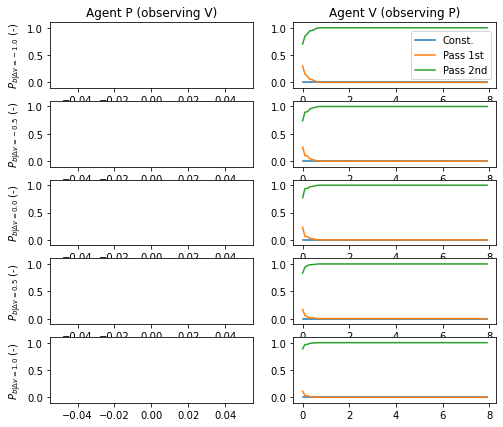

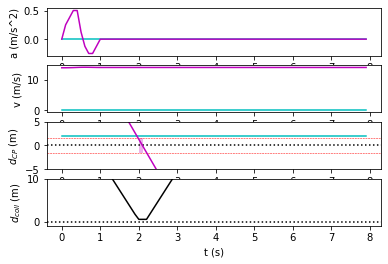


	--- ActVehStatPedPrio


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


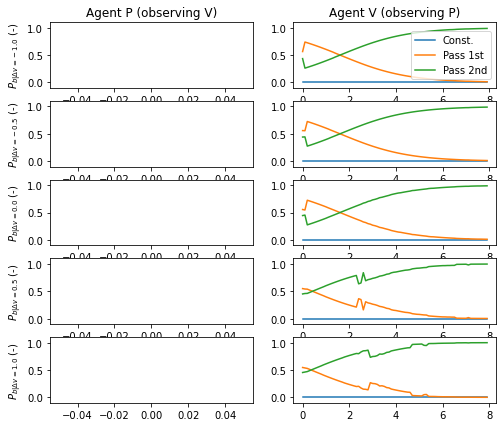

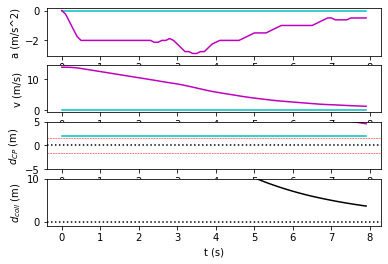

10/28/21 18:36:44 oVAaoVAloBEooBEvo -> Running simulations for parameterisation {'T_delta': 15, 'thetaDot_1': 0.01, 'beta_V': 5, 'T_Of': inf, 'sigma_O': 0.1}...


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:192: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Surplus deceleration: 1.4183073849515067 m/s^2

	--- ActPedPrioEncounter


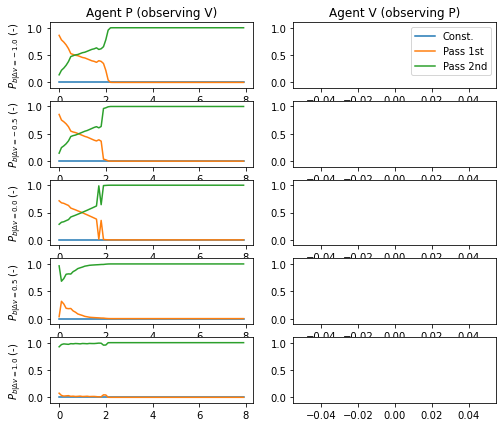

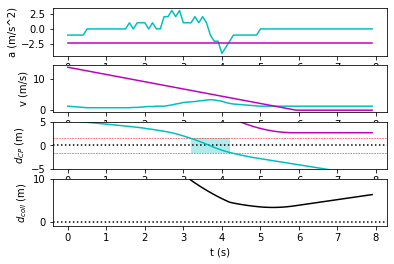

In [48]:
import math
import sc_fitting
fit = det_fits['oVAaoVAloBEooBEvoAI']
params_array = (15, 0.01, 5, math.inf, 0.1)
fit.set_params(params_array)
print(fit.get_params_dict(params_array))
for scenario in ('ActVehStatPed', 'ActVehStatPedPrio', 'ActPedPrioEncounter'):
    print(f'\n\t--- {scenario}')
    sim = fit.simulate_scenario(sc_fitting.DET1S_SCENARIOS[scenario], snapshots=snapshots)
    sim.do_plots(kinem_states=True, beh_probs=True)
    if scenario == 'ActVehStatPedPrio':
        metrics_array = fit.get_metrics_for_params(params_array)
        i_metric = sc_fitting.DET1S_METRIC_NAMES.index('ActVehStatPedPrio_veh_max_surplus_dec_before')
        print(f'Surplus deceleration: {metrics_array[i_metric]} m/s^2')

## Conclusions

Some possible next steps here:
* Wrt the unrealistic behaviours, I could go in and add acceleration and speed limits in the behaviours that the agents assume of the other agents. That would be reasonably easy in some sense given the current numerical integration approach, but it feels potentially a bit ad hoc and might open other cans of worms.
* Wrt "not enough looming aversion", I could run an expanded grid.

Overall though I am feeling now that the pedestrian hesitation might be a bit of a red herring also in the vehicle deceleration scenario, for the reasons mentioned above - where priority assertion and deceleration are opposing forces. So maybe the model needs observation noise for sensible deceleration also in the `ActPedPrioEncounter` scenario, just as I have concluded that it probably needs it for the `ActPedLeading` scenario.

In any case, it's definitely time to start transitioning to the probabilistic simulations very soon here - I feel like I should not be further convoluting the deterministic parts of the model.
